In [1]:
import tensorflow as tf
from keras import layers, Model, callbacks
import numpy as np
from PIL import Image
import os
import pandas as pd
import io
from super_token import Tokenizer
import json
import matplotlib.pyplot as plt
img_size = 96

2023-11-27 00:58:24.315114: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 00:58:24.335865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 00:58:24.335889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 00:58:24.335901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 00:58:24.339951: I tensorflow/core/platform/cpu_feature_g

In [2]:
def load_dataset(parquet_file_path):
    df = pd.read_parquet(parquet_file_path, engine="pyarrow")

    captions = df["text"].tolist()
    captions = captions[:25000] # Adjust based off how much GPU memory you have.
    im_df = df["image"].tolist()
    im_df = im_df[:25000]
    images = []
    for img_dict in im_df:
        if "bytes" in img_dict:
            img_data = img_dict["bytes"]
            image = Image.open(io.BytesIO(img_data)).convert("RGB")
            image = image.resize((img_size, img_size))
            image = np.array(image) / 255.0
            images.append(image)

    return captions, np.array(images)

In [3]:
def load_datasetX(directory_path, img_size):
    captions = []
    images = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".parquet"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_parquet(file_path, engine="pyarrow")
            captions.extend(df["caption"].tolist())

            for img_dict in df["image"]:
                if "bytes" in img_dict:
                    img_data = img_dict["bytes"]
                    image = Image.open(io.BytesIO(img_data)).convert("RGB")
                    print(image.size)
                    image = image.resize((img_size, img_size))
                    # Sigmoid values range between 0-1
                    image = np.array(image) / 255.0
                    # image = (np.array(image) / 127.5) - 1.0 # Hyperbolic tanh values range between -1 to 1
                    images.append(image)

    return captions, np.array(images)

In [4]:
def pad_sequences(sequences, maxlen, padding="post", truncating="post"):
    padded_sequences = []
    for seq in sequences:
        if len(seq) >= maxlen:
            if truncating == "pre":
                padded_seq = seq[-maxlen:]
            else:
                padded_seq = seq[:maxlen]
        else:
            if padding == "post":
                padded_seq = seq + [0] * (maxlen - len(seq))
            else:
                padded_seq = [0] * (maxlen - len(seq)) + seq
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

In [5]:
def texts_to_padded_sequences(texts, max_length, num_words):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(
        sequences, maxlen=max_length, padding="post", truncating="post"
    )

    return padded_sequences, tokenizer

In [6]:
parquet_file_path = "data/pixels.parquet"
text, images = load_dataset(parquet_file_path)
# directory_path = "b4"
# img_size = 64  # Define your desired image size
# text, images = load_datasetX(directory_path, img_size)

In [7]:
max_length = 50
num_words = 400
text_input_shape = max_length
batchy = 1

texts, tokenizer = texts_to_padded_sequences(text, max_length, num_words)


num_words = len(tokenizer.word_index) + 1
print('Num words:', num_words)
max_length = max(len(text.split()) for text in text)
print('Max Length:',max_length)

Num words: 315
Max Length: 26


a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background
a pixel art character with square black sunglasses, a shower-shaped head and a blue-colored body on a cool background
a pixel art character with square dark green glasses, a yeti-shaped head and a redpinkish-colored body on a cool background
a pixel art character with square dark gray glasses, a void-shaped head and a teal-colored body on a warm background
a pixel art character with square dark green glasses, a rainbow-shaped head and a orange-colored body on a cool background
a pixel art character with square blue glasses, a couch-shaped head and a gold-colored body on a cool background
a pixel art character with square orange glasses, a chef hat-shaped head and a purple-colored body on a cool background
a pixel art character with square red glasses, a blackhole-shaped head and a teal-colored body on a cool background
a pixel art character with square dark green glasses

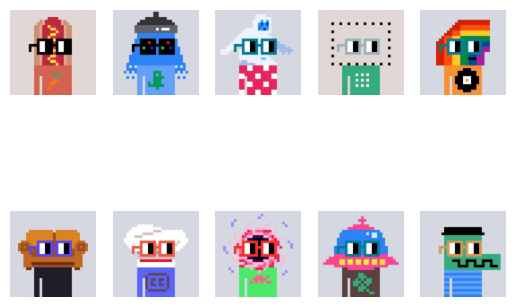

Number of images: 25000


In [8]:

#print row of the first 5 images
for i in range(10):
    print(text[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

# Dataset size
print("Number of images:", len(images))

In [9]:


def pseudo_swish(x):
    return layers.ReLU()(x) + 0.1 * tf.sigmoid(x)  # Adjust the scaling factor as needed

def add_conv_block(x, filters, kernel_size, strides, use_maxpool=True, use_dropout=False):
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = pseudo_swish(x)  # Using the pseudo-swish activation
    x = layers.BatchNormalization()(x)
    if use_maxpool:
        x = layers.MaxPooling2D((2, 2))(x)
    if use_dropout:
        x = layers.Dropout(0.4)(x)
    return x

def create_combined_model(text_input_length, img_size):
    text_input = layers.Input(batch_shape=(1, text_input_length))
    image_input = layers.Input(batch_shape=(1, img_size, img_size, 3))

    x_img = add_conv_block(image_input, 128, [5, 5], strides=[1, 1])
    x_img = add_conv_block(x_img, 128, [5, 5], strides=[1, 1])
    x_img = add_conv_block(x_img, 256, [5, 5], strides=[2, 2])  # Increased stride
    x_img = add_conv_block(x_img, 256, [5, 5], strides=[1, 1], use_maxpool=False)
    x_img = add_conv_block(x_img, 512, [5, 5], strides=[2, 2], use_dropout=True)  # Increased stride
    x_img = add_conv_block(x_img, 512, [5, 5], strides=[1, 1], use_maxpool=False, use_dropout=True)

    # Combine text and image features
    x_img = layers.Flatten()(x_img)
    combined = layers.concatenate([text_input, x_img])

    # Final layers
    x = layers.Dense(128, activation=pseudo_swish)(combined)
    x = layers.Dropout(0.5)(x)  
    output = layers.Dense(img_size * img_size * 3, activation="sigmoid")(x)  
    output = layers.Reshape((img_size, img_size, 3))(output)

    return Model(inputs=[text_input, image_input], outputs=output)

# def add_conv_block(x, filters, kernel_size, strides, use_maxpool=True, use_dropout=False):
#     x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.1)(x)  # Using LeakyReLU
#     x = layers.BatchNormalization()(x)
#     if use_maxpool:
#         x = layers.MaxPooling2D((2, 2))(x)
#     if use_dropout:
#         x = layers.Dropout(0.4)(x)
#     return x

# def ResBlock(x, filters):
#     # This block will use simple skip connections and BatchNormalization for compatibility
#     residual = x
#     x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(alpha=0.1)(x)  # Using LeakyReLU
#     x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.add([x, residual])  # Add the input (residual) to the output of the convolutions
#     x = layers.LeakyReLU(alpha=0.1)(x)  # Apply LeakyReLU after adding the residual
#     return x

# def create_combined_model(text_input_length, img_size):
#     text_input = layers.Input(batch_shape=(1, text_input_length))
#     image_input = layers.Input(batch_shape=(1, img_size, img_size, 3))

#     x_img = add_conv_block(image_input, 128, [5, 5], strides=[1, 1])
#     x_img = ResBlock(x_img, 128)
#     x_img = add_conv_block(x_img, 256, [5, 5], strides=[2, 2])
#     x_img = ResBlock(x_img, 256)
#     x_img = add_conv_block(x_img, 512, [5, 5], strides=[2, 2])
#     x_img = ResBlock(x_img, 512)

#     # Combine text and image features
#     x_img = layers.Flatten()(x_img)
#     combined = layers.concatenate([text_input, x_img])

#     # Final layers
#     x = layers.Dense(128, activation=pseudo_swish)(combined)
#     x = layers.Dropout(0.5)(x)
#     output = layers.Dense(img_size * img_size * 3, activation='sigmoid')(x)
#     output = layers.Reshape((img_size, img_size, 3))(output)

#     return Model(inputs=[text_input, image_input], outputs=output)

In [10]:
batch_size=2
combined_model = create_combined_model(text_input_shape, img_size)
combined_model.compile(optimizer="adam", loss="mean_squared_error")
combined_model.fit([texts, images], images, epochs=100, batch_size=batch_size) # Increasing the num of epochs makes the image generation worse
combined_model.save("combined_model", save_format="tf")
model = tf.keras.models.load_model("combined_model")
print(model.summary())


2023-11-27 00:58:46.504534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 00:58:46.507729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 00:58:46.507757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 00:58:46.509868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 00:58:46.509893: I tensorflow/compile

Epoch 1/100


2023-11-27 00:58:53.532466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-27 00:58:54.336725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-27 00:58:55.771560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f868a41ff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 00:58:55.771598: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-27 00:58:55.774913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 00:58:55.839281: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled 

In [ ]:
representative_texts = texts[:200]
representative_images = images[:200]


In [ ]:
# batch_size=8
def representative_dataset_generator():
    for i in range(len(representative_texts)):
        text_input = representative_texts[i].astype(np.float32).reshape(1, -1)
        image_input = (
            representative_images[i]
            .astype(np.float32)
            .reshape(1, img_size, img_size, 3)
        )
        yield [text_input, image_input]
        #yield [image_input, text_input]


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(combined_model)
converter.representative_dataset = representative_dataset_generator
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert the model
tflite_model = converter.convert()

In [ ]:
with open("models/budget_diffusion.tflite", "wb") as f:
    f.write(tflite_model)

tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as json_file:
    json.dump(tokenizer_json, json_file)

In [ ]:
!edgetpu_compiler -d -a ./models/budget_diffusion.tflite

In [ ]:
##!python3 run_on_coral.py